Liz's Results are in http://crick.bio.uci.edu/erebboah/postnatal_splitseq/adrenal/ENCSR193PLQ/ I should use the unfiltered?

In [1]:
import csv
from collections import Counter
import scanpy
import pysam
from pathlib import Path
import pandas
import requests
import numpy
import os
import re
import shutil
import scipy
import gzip
import sys
from matplotlib import pyplot
import matplotlib
import upsetplot
import warnings
from urllib.parse import urljoin

In [2]:
EC = str(Path("~/proj/encoded_client").expanduser())
if EC not in sys.path:
    sys.path.append(EC)
from encoded_client import ENCODED

In [3]:
MEX = str(Path("~/proj/mex_gene_archive").expanduser())
if MEX not in sys.path:
    sys.path.append(MEX)
from mex_gene_archive.filter import write_filtered_mtx    

In [4]:
WRS = str(Path("~/proj/woldlab-rna-seq").expanduser())
if WRS not in sys.path:
    sys.path.append(WRS)
from woldrnaseq.plots.scrna_matrix_qc import (
    calculate_qc,
    generate_violin_plot,
    make_pct_mt_scatter,
    make_gene_by_count_scatter,
)


In [5]:
from common import scanpy_load_solo_mtx

In [6]:
%matplotlib inline

In [7]:
star_analysis_dir = Path("adrenal/mouse_adr_2k_a4_f1")
erebboah_base = "http://crick.bio.uci.edu/erebboah/postnatal_splitseq/adrenal/A_4_F_1/DGE_unfiltered/"

In [8]:
gene_id_name_map = {}
genome_dir = Path("~/proj/genome/mm10-M21-male-2.7.9a").expanduser()
with open(genome_dir / "geneInfo.tab", "rt") as instream:
    count = instream.readline()
    for line in instream:
        gene_id, gene_name, gene_type = line.rstrip().split("\t")
        if gene_name == "NULL":
            gene_name = gene_id
        gene_id_name_map[gene_id] = gene_name
        


In [9]:
parse_mapper = {
    "v1": {
        'ACTCGTAA': '0', 'CTGCTTTG': '0',
        'AAACGATA': '1', 'CATGATCA': '1',
        'TTACCTCG': '2', 'GGGTAGCG': '2',
        'GCCTGCAA': '3', 'CCGAGAAA': '3',
        'TGGTATAC': '4', 'ACGGACTC': '4',
        'CGTTCGAG': '5', 'ACTTACGA': '5',
        'TCTATTAC': '6', 'TATTTAAG': '6',
        'ATAAGCTC': '7', 'ACCGTACG': '7',
        'ATTCATGG': '8', 'TATAGTCG': '8',
        'ATCCGCGA': '9', 'TGGGCATC': '9',
        'ATCGCATA': '10', 'TACCTAGA': '10',
        'CCGTTCTA': '11', 'GCTGCATG': '11',
        'TGGCGCGC': '12', 'GTCATATG': '12',
        'TGTCTGAA': '13', 'ATATTGGC': '13',
        'CTGTCCCG': '14', 'CTAAGGGA': '14',
        'AATTTCTC': '15', 'TCGTTTCG': '15',
        'CGCGACTA': '16', 'GAATAATG': '16',
        'TGAAGCAA': '17', 'ACTGCGCA': '17',
        'TTATTCTG': '18', 'GCTTATAG': '18',
        'GTTCAACA': '19', 'ATCATGCA': '19',
        'ACGCCGGC': '20', 'ACGTTAAC': '20',
        'TTGTCTTA': '21', 'CCATCTTG': '21',
        'TACGGTTA': '22', 'CATAGCTA': '22',
        'TTGGGAGA': '23', 'GAGGTTGA': '23',
        'TGCTTGGG': '24', 'GCACTGAC': '24',
        'TAAATATC': '25', 'TTCATCGC': '25',
        'CACAATTG': '26', 'GAAATTAG': '26',
        'GTGCTAGC': '27', 'AGGATTAA': '27',
        'CGCCCGGA': '28', 'AATAGAAC': '28',
        'GCTCGCGG': '29', 'TCTTAATC': '29',
        'CTTTGGTC': '30', 'TAATACGC': '30',
        'TTCCGATC': '31', 'GTTTGTGA': '31',
        'TTCGCTAC': '32', 'CGAACGTC': '32',
        'AGCGAAAC': '33', 'GGTTCTTC': '33',
        'AAATAGCA': '34', 'GCAAATTC': '34',
        'CGTCTAGG': '35', 'GCTATGCG': '35',
        'GCCGTGTA': '36', 'CTACCCTA': '36',
        'CGCTTAAA': '37', 'GTGGGTTC': '37',
        'GACCTTTC': '38', 'GTCCGTAG': '38',
        'GGTGGAGC': '39', 'TGCGATCG': '39',
        'TACTCGAA': '40', 'TATCCGGG': '40',
        'CATTTGGA': '41', 'AGGTAATA': '41',
        'GAGCACAA': '42', 'CGTGGTTG': '42',
        'GTCGCGCG': '43', 'GACAAAGC': '43',
        'GTTACGTA': '44', 'GGGCGATG': '44',
        'CTATTTCA': '45', 'ATCTATAA': '45',
        'ACTATATA': '46', 'GCCCATGA': '46',
        'TCACTTTA': '47', 'CTGAAAGG': '47'
    }
}

from scipy.io.mmio import MMFile

class SimpleFloatMMWriter(MMFile):
    @staticmethod
    def _field_template(field, precision):
        return {MMFile.FIELD_REAL: '%%.%ig\n' % precision,
                MMFile.FIELD_INTEGER: '%i\n',
                MMFile.FIELD_UNSIGNED: '%u\n',
                MMFile.FIELD_COMPLEX: '%%.%ie %%.%ie\n' %
                    (precision, precision)
                }.get(field, None)

def read_parse_cell_barcode_lineno_map(stream):
    barcodes = {}
    reader = csv.reader(stream, delimiter="\t")
    for i, line in enumerate(reader):
        barcodes[line[0]] = i + 1

    return barcodes

def read_feature_lineno_map(stream):
    barcodes = {}
    reader = csv.reader(stream, delimiter="\t")
    for i, line in enumerate(reader):
        barcodes[line[0]] = i + 1

    return barcodes

def compute_parse_map(raw_barcodes, mapper):
    raw_to_collapsed_mapping = {}
    combined_indexes = {}
    for barcode in raw_barcodes:
        fragments = barcode.split("_")
        fragments[2] = str(mapper[fragments[2]])
        combined_barcode = "{}{}_{}".format(*fragments)
        
        combined_index = combined_indexes.setdefault(combined_barcode, len(combined_indexes)+1)
        raw_index = raw_barcodes[barcode]
        raw_to_collapsed_mapping[raw_index] = combined_index
    return (combined_indexes, raw_to_collapsed_mapping)


def _parse_mmread(matrix_filename, merged_barcodes, merged_mapping):
    header = True
    matrix = None
    with open(matrix_filename, "rt") as instream:
        for line in instream:
            if line.startswith("%"):
                pass
            elif header:
                # After the comment comes the one header line
                total_features, total_cells, total_counts = [
                    int(x) for x in line.rstrip().split()
                ]
                matrix = scipy.sparse.dok_matrix((len(merged_barcodes), total_features), dtype=float)
                header = False
            else:
                # row, column, count
                feature_index, cell_index, count = line.rstrip().split()
                feature_index = int(feature_index)
                cell_index = int(cell_index)
                count = float(count)
                
                new_cell_index = merged_mapping[cell_index]
                matrix[new_cell_index-1, feature_index-1] = matrix.get((new_cell_index-1, feature_index-1), 0) + count

    return matrix

def load_parse_mtx(analysis_dir, *, gene="Gene", mode="filtered", multi="matrix.mtx"):
    assert mode in ["filtered", "raw"], "STAR Solo only produces raw or filtered files"
    assert gene in ["SJ", "Gene", "GeneFull_Ex50pAS", "GeneFull"]
    assert multi in ["matrix.mtx", "UniqueAndMult-EM.mtx"]

    analysis_dir = Path(analysis_dir)
    solo_dir = analysis_dir / "Solo.out" / gene / mode
    cell_barcode_filename = solo_dir / "barcodes.tsv"
    feature_filename = solo_dir / "features.tsv"
    matrix_filename = solo_dir / multi
    
    with open(cell_barcode_filename, "rt") as instream:
        cell_barcodes = read_parse_cell_barcode_lineno_map(instream)
    with open(feature_filename, "rt") as instream:
        features = read_feature_lineno_map(instream)
    merged_barcodes, merged_mapping = compute_parse_map(cell_barcodes, parse_mapper["v1"])

    matrix = _parse_mmread(matrix_filename, merged_barcodes, merged_mapping)
    print("Loading matrix shape", matrix.shape)

    return matrix, list(merged_barcodes.keys()), list(features.keys())

def write_parse_mtx(analysis_dir, output_dir, *, gene="Gene", mode="filtered", multi="matrix.mtx"):
    matrix, cells, features = load_parse_mtx(analysis_dir, gene=gene, mode=mode, multi=multi)
    output_dir = Path(output_dir)
    with open(output_dir / "barcodes.tsv", "wt") as outstream:
        for barcode in cells:
            outstream.write(barcode)
            outstream.write(os.linesep)

    solo_dir = analysis_dir / "Solo.out" / gene / mode
    feature_filename = solo_dir / "features.tsv"
    shutil.copy(feature_filename, output_dir / "features.tsv")
    
    matrix_name = output_dir / multi
    matrix = matrix.T
    
    assert matrix.shape[1] == len(cells), "The number of rows doesn't match the number of barcodes"
    assert matrix.shape[0] == len(features), "The number of columns doesn't match the number of features"
    print("Writing matrix.shape", matrix.shape, matrix_name)
    SimpleFloatMMWriter().write(matrix_name, matrix, comment='', field=None, precision=None, symmetry=None)
    

def load_parse_anndata(analysis_dir, *, gene="Gene", mode="filtered", multi="matrix.mtx"):
    matrix, cells, features = load_parse_mtx(analysis_dir, gene=gene, mode=mode, multi=multi)

    obs = pandas.DataFrame(cells, index=cells, columns=["cell_barcodes"])
    var = pandas.DataFrame(features, index=features, columns=["gene_id"])
    adata = scanpy.AnnData(matrix.tocsr(), obs=obs, var=var)

    return adata

def load_parse_decoder(filename):
    parse_barcodes = {}
    tsv = pandas.read_csv(filename, sep="\t", index_col=0).set_index("well")
    for index, row in tsv.iterrows():
        parse_barcodes[row["bc1_dt"]] = index
        parse_barcodes[row["bc1_randhex"]] = index
    return parse_barcodes

#def group_parse_barcodes(adata, parse_barcodes):
class DecodeParse:
    def __init__(self, parse_barcodes):
        self._parse_barcodes = parse_barcodes
        
    def __call__(self, barcode):
        barcodes = barcode.split("_")
        suffix = self._parse_barcodes[barcodes[2]]
        return "{}{}_{}".format(barcodes[0], barcodes[1], suffix)

def load_parse_mtx(analysis_dir, barcodes="bc_dt_randhex.tsv", gene="Gene", mode="filtered", multi="matrix.mtx"):
    decode_parse = DecodeParse(load_parse_decoder(barcodes))
    
    star_run = scanpy_load_solo_mtx(star_analysis_dir, gene=gene, mode=mode, multi=multi)
    star_run.obs["parse_group"] = [decode_parse(x) for x in star_run.obs_names]

    parse_group = pandas.Series(
        Counter(star_run.obs["parse_group"]).keys(),
        index=Counter(star_run.obs["parse_group"]).keys()
    )
    parse_group.name = "cell barcodes"

    var_names = star_run.var_names.to_series()
    var_names.name = "gene_id"

    coo_shape = (len(parse_group), star_run.X.shape[1])
    sparse = scipy.sparse.lil_matrix(coo_shape, dtype=star_run.X.dtype)
    for row, key in enumerate(parse_group):
        sparse[row] = star_run[star_run.obs["parse_group"] == key].X.sum(axis=0)

    mergedrun = scanpy.AnnData(sparse.tocsr(), obs=parse_group.to_frame(), var=var_names.to_frame())
    for key in star_run.var_keys():
        mergedrun.var[key] = star_run.var[key]
    
    return mergedrun

In [10]:
myrun = load_parse_anndata(star_analysis_dir, gene="GeneFull_Ex50pAS")
calculate_qc(myrun, gene_id_name_map)

print("count sum", myrun.X.sum().sum())
print("shape", myrun.shape)
myrun

Loading matrix shape (194, 81881)
count sum 297095.0
shape (194, 81881)


AnnData object with n_obs × n_vars = 194 × 81881
    obs: 'cell_barcodes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [11]:
myrunem = load_parse_anndata(star_analysis_dir, gene="GeneFull_Ex50pAS", multi="UniqueAndMult-EM.mtx")
calculate_qc(myrunem, gene_id_name_map)

print("count sum", myrunem.X.sum().sum())
print("shape", myrunem.shape)

Loading matrix shape (194, 81881)
count sum 306770.03
shape (194, 81881)


In [12]:
myrun_raw = load_parse_anndata(star_analysis_dir, gene="GeneFull_Ex50pAS", mode="raw")

calculate_qc(myrun_raw, gene_id_name_map)

print("count sum", myrun_raw.X.sum().sum())
print("shape", myrun_raw.shape)

Loading matrix shape (442368, 81881)
count sum 414886.0
shape (442368, 81881)


In [13]:
myrunem_raw = load_parse_anndata(star_analysis_dir, gene="GeneFull_Ex50pAS", mode="raw", multi="UniqueAndMult-EM.mtx")
calculate_qc(myrunem_raw, gene_id_name_map)

print("count sum", myrunem_raw.X.sum().sum())
print("shape", myrunem_raw.shape)

Loading matrix shape (442368, 81881)
count sum 428539.03
shape (442368, 81881)


Collapse unique and multi raw matricies

In [14]:
raw_collapsed_parse_filtered = star_analysis_dir / "Solo.out" / "GeneFull_Ex50pAS" / "raw_collapsed"

if not raw_collapsed_parse_filtered.exists():
    raw_collapsed_parse_filtered.mkdir()

write_parse_mtx(star_analysis_dir, raw_collapsed_parse_filtered, gene="GeneFull_Ex50pAS", mode="raw")

Loading matrix shape (442368, 81881)
Writing matrix.shape (81881, 442368) adrenal/mouse_adr_2k_a4_f1/Solo.out/GeneFull_Ex50pAS/raw_collapsed/matrix.mtx


In [15]:
raw_collapsed_parse_filtered = star_analysis_dir / "Solo.out" / "GeneFull_Ex50pAS" / "raw_collapsed"

if not raw_collapsed_parse_filtered.exists():
    raw_collapsed_parse_filtered.mkdir()

write_parse_mtx(star_analysis_dir, raw_collapsed_parse_filtered, gene="GeneFull_Ex50pAS", multi="UniqueAndMult-EM.mtx", mode="raw")

Loading matrix shape (442368, 81881)
Writing matrix.shape (81881, 442368) adrenal/mouse_adr_2k_a4_f1/Solo.out/GeneFull_Ex50pAS/raw_collapsed/UniqueAndMult-EM.mtx


Use star to apply EmptyDrops_CR cell filtering to raw collapsed matrix creating filtered uniq matrix

In [16]:
!~/proj/STAR/bin/Linux_x86_64_static/STAR --runMode soloCellFiltering \
  $star_analysis_dir/Solo.out/GeneFull_Ex50pAS/raw_collapsed/  \
  $star_analysis_dir/Solo.out/GeneFull_Ex50pAS/filtered_collapsed/ \
  --soloCellFilter EmptyDrops_CR

	/woldlab/loxcyc/home/diane/proj/STAR/bin/Linux_x86_64_static/STAR --runMode soloCellFiltering adrenal/mouse_adr_2k_a4_f1/Solo.out/GeneFull_Ex50pAS/raw_collapsed/ adrenal/mouse_adr_2k_a4_f1/Solo.out/GeneFull_Ex50pAS/filtered_collapsed/ --soloCellFilter EmptyDrops_CR
	STAR version: dev_EoI_2.7.9a_2021-12-22   compiled: 2021-12-22T08:42:40-05:00 :/home/dobin/data/STAR/STARcode/STAR.master/source
Jan 07 16:30:06 ..... started STAR run
Jan 07 16:30:06 ..... starting SoloCellFiltering
Jan 07 16:30:06 ..... finished successfully


Use raw EM matrix and filtered uniq matrix to create EM matrix

In [17]:
write_filtered_mtx(
    star_analysis_dir / "Solo.out" / "GeneFull_Ex50pAS" / "raw_collapsed" / "barcodes.tsv",
    star_analysis_dir / "Solo.out" / "GeneFull_Ex50pAS" / "raw_collapsed" / "UniqueAndMult-EM.mtx",
    star_analysis_dir / "Solo.out" / "GeneFull_Ex50pAS" / "filtered_collapsed" / "barcodes.tsv",
    star_analysis_dir / "Solo.out" / "GeneFull_Ex50pAS" / "filtered_collapsed" / "UniqueAndMult-EM.mtx",
)

In [18]:
myrun_filtered_collapsed = scanpy_load_solo_mtx(star_analysis_dir, gene="GeneFull_Ex50pAS", mode="filtered_collapsed")

calculate_qc(myrun_filtered_collapsed, gene_id_name_map)

print("count sum", myrun_filtered_collapsed.X.sum().sum())
print("shape", myrun_filtered_collapsed.shape)

count sum 324036.0
shape (329, 81881)


In [19]:
myrunem_filtered_collapsed = scanpy_load_solo_mtx(star_analysis_dir, gene="GeneFull_Ex50pAS", mode="filtered_collapsed", multi="UniqueAndMult-EM.mtx")

calculate_qc(myrunem_filtered_collapsed, gene_id_name_map)

print("count sum", myrunem_filtered_collapsed.X.sum().sum())
print("shape", myrunem_filtered_collapsed.shape)

count sum 334637.03
shape (329, 81881)


In [20]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [21]:
myrun_raw_collapsed = scanpy_load_solo_mtx(star_analysis_dir, gene="GeneFull_Ex50pAS", mode="raw_collapsed")

calculate_qc(myrun_raw_collapsed, gene_id_name_map)

print("count sum", myrun_raw_collapsed.X.sum().sum())
print("shape", myrun_raw_collapsed.shape)

count sum 414886.0
shape (442368, 81881)


In [22]:
myrunem_raw_collapsed = scanpy_load_solo_mtx(star_analysis_dir, gene="GeneFull_Ex50pAS", mode="raw_collapsed", multi="UniqueAndMult-EM.mtx")

calculate_qc(myrunem_raw_collapsed, gene_id_name_map)

print("count sum", myrunem_raw_collapsed.X.sum().sum())
print("shape", myrunem_raw_collapsed.shape)

count sum 428539.03
shape (442368, 81881)


In [23]:
req = requests.get(urljoin(erebboah_base, "DGE.mtx"), stream=True)
uci_dge = scipy.io.mmread(req.raw)

ucirun = scanpy.AnnData(uci_dge.tocsr())

print("uci count sum", ucirun.X.sum().sum())
print("uci", ucirun)

uci count sum 392113.0
uci AnnData object with n_obs × n_vars = 2721 × 13996


In [24]:
cell_metadata = pandas.read_csv(urljoin(erebboah_base, "cell_metadata.csv"), index_col=0)
ucirun.obs_names = cell_metadata["cell_barcode"]
cell_metadata.head()

,cell_barcode,species,sample,rnd1_well,rnd2_well,rnd3_well,umi_count,umi_count_50dup,gene_count
0,AAGACGGAAATGTTGC_0,mm10,A_4_F_1,0,72,15,72628,53560.108711,10249
1,ATCCTGTATGGCTTCA_0,mm10,A_4_F_1,0,65,27,7827,5772.084745,3521
2,CTCAATGATCTTCACA_0,mm10,A_4_F_1,0,62,42,7597,5602.469377,3151
3,TAGGATGAAGTGGTCA_0,mm10,A_4_F_1,0,3,59,5865,4325.191904,2849
4,ACTATGCAAATGTTGC_0,mm10,A_4_F_1,0,72,22,5386,3971.949462,2835


In [25]:
genes = pandas.read_csv(urljoin(erebboah_base, "genes.csv"), index_col=0)
genes

,gene_id,gene_name,genome
0,ENSMUSG00000000001.4,Gnai3,mm10
1,ENSMUSG00000000028.15,Cdc45,mm10
2,ENSMUSG00000000031.16,H19,mm10
3,ENSMUSG00000000037.16,Scml2,mm10
4,ENSMUSG00000000058.6,Cav2,mm10
...,...,...,...
13991,ENSMUSG00000118346.1,Tmem179b,mm10
13992,ENSMUSG00000118352.1,AC133941.2,mm10
13993,ENSMUSG00000118362.1,AC116597.1,mm10
13994,ENSMUSG00000118373.1,AC131065.5,mm10


In [26]:
ucirun.var_names = genes["gene_id"]
ucirun.var["gene_name"] = genes["gene_name"].values

In [27]:
mt_prefix = re.compile("^mt[-_]", re.I)
ucirun.var["mt"] = ucirun.var["gene_name"].apply(lambda x: mt_prefix.match(x) is not None)
scanpy.pp.calculate_qc_metrics(
    ucirun, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)


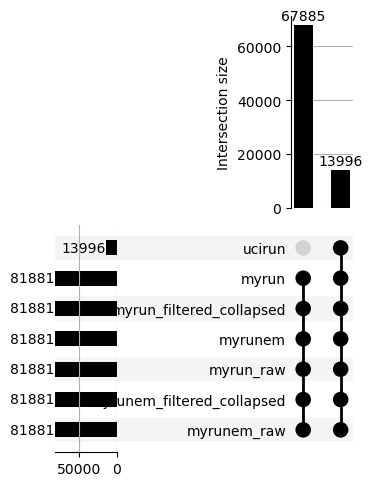

In [28]:
upset_gene_contents = upsetplot.from_contents({
    'myrun': myrun.var_names,
    'myrun_filtered_collapsed': myrun_filtered_collapsed.var_names,
    'myrunem': myrunem.var_names,
    'myrun_raw': myrun_raw.var_names,
    'myrunem_filtered_collapsed': myrunem_filtered_collapsed.var_names,
    'myrunem_raw': myrunem_raw.var_names,
    'ucirun': ucirun.var_names,
})
f = pyplot.figure(dpi=100)
_ = upsetplot.plot(upset_gene_contents, fig=f, show_counts=True)

In [29]:
len(set(myrun.obs_names)), myrun.obs_names.shape

(194, (194,))

In [30]:
len(set(ucirun.obs_names)), ucirun.obs_names.shape

(2721, (2721,))

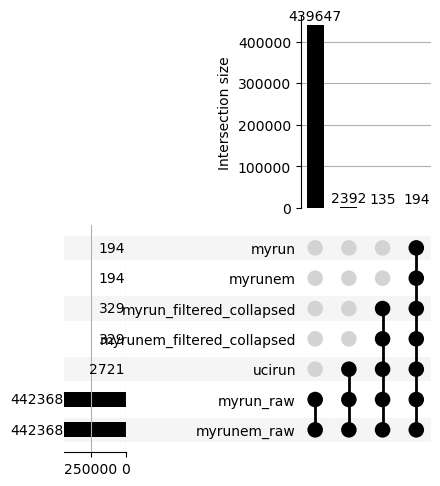

In [31]:
upset_barcode_contents = upsetplot.from_contents({
    'myrun': myrun.obs_names,
    'myrun_filtered_collapsed': myrun_filtered_collapsed.obs_names,
    'myrunem': myrunem.obs_names,
    'myrunem_filtered_collapsed': myrunem_filtered_collapsed.obs_names,
    'myrun_raw': myrun_raw.obs_names,
    'myrunem_raw': myrunem_raw.obs_names,
    'ucirun': set(ucirun.obs_names),
})
f = pyplot.figure(dpi=100)
_ = upsetplot.plot(upset_barcode_contents, fig=f, show_counts=True)

In [32]:
warnings.filterwarnings("ignore", "Vertical orientation")

# STAR Violin

... storing 'gene_name' as categorical


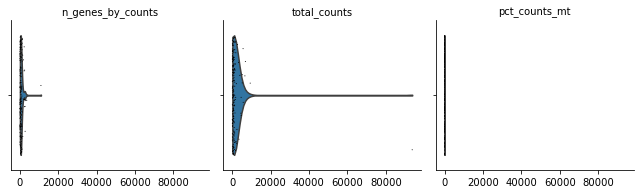

In [33]:
ag = generate_violin_plot(myrun)

# STAR Violin EM

... storing 'gene_name' as categorical


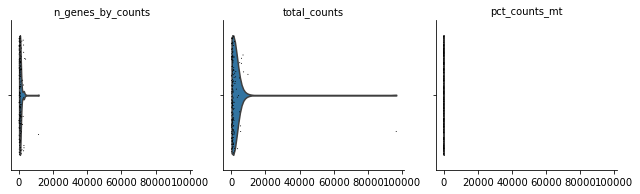

In [34]:
ag = generate_violin_plot(myrunem)

... storing 'gene_name' as categorical


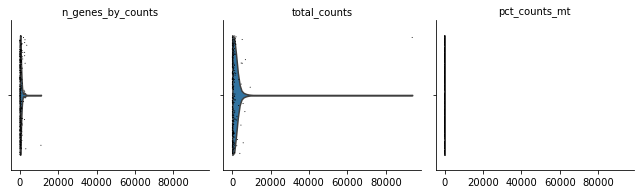

In [35]:
ag = generate_violin_plot(myrun_filtered_collapsed)

... storing 'gene_name' as categorical


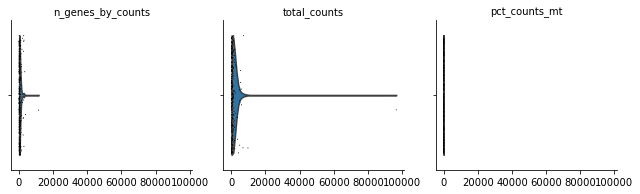

In [36]:
ag = generate_violin_plot(myrunem_filtered_collapsed)

... storing 'gene_name' as categorical


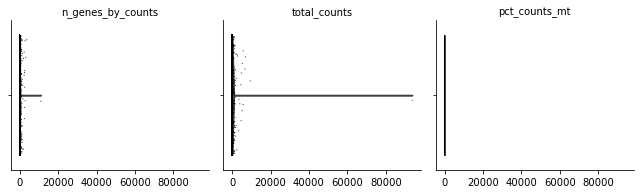

In [37]:
ag = generate_violin_plot(myrun_raw_collapsed)

... storing 'gene_name' as categorical


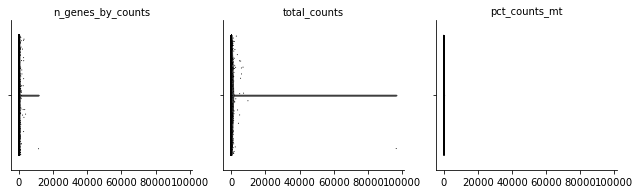

In [38]:
ag = generate_violin_plot(myrunem_raw_collapsed)

# UCI Violin

... storing 'gene_name' as categorical


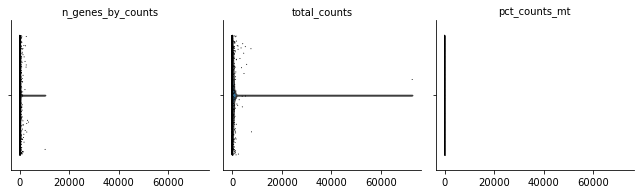

In [39]:
ag = generate_violin_plot(ucirun)

# STAR pct mt

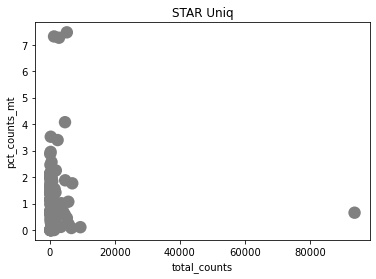

In [40]:
f = make_pct_mt_scatter(myrun, "STAR Uniq")

# STAR EM pct mt

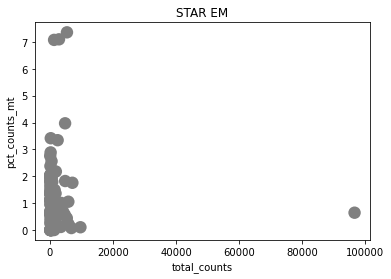

In [41]:
f = make_pct_mt_scatter(myrunem, "STAR EM")

# UCI pct mt

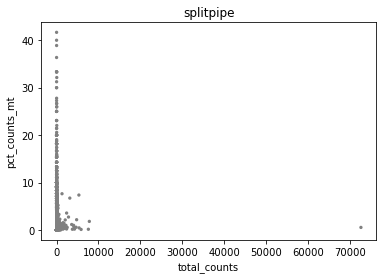

In [42]:
f = make_pct_mt_scatter(ucirun, "splitpipe")

# STAR gene by count

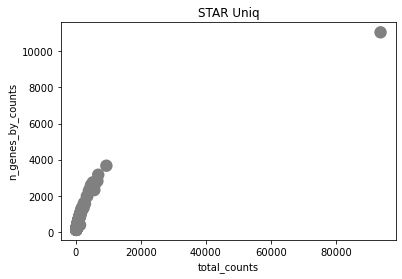

In [43]:
f = make_gene_by_count_scatter(myrun, "STAR Uniq")

# STAR EM gene by count

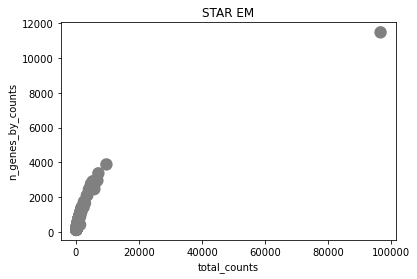

In [44]:
f = make_gene_by_count_scatter(myrunem, "STAR EM")

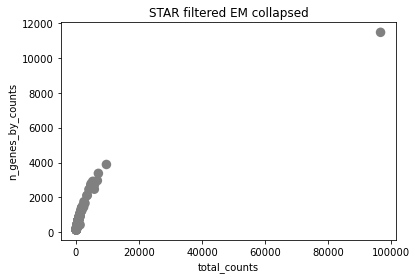

In [45]:
f = make_gene_by_count_scatter(myrunem_filtered_collapsed, "STAR filtered EM collapsed")

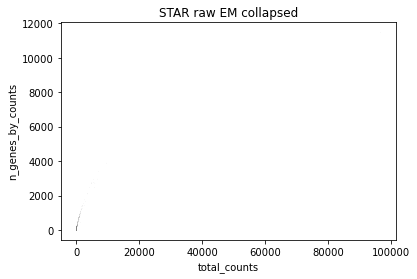

In [46]:
f = make_gene_by_count_scatter(myrunem_raw_collapsed, "STAR raw EM collapsed")

# UCI gene by count

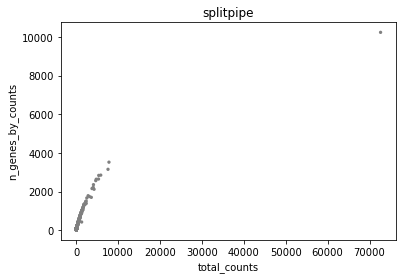

In [47]:
f = make_gene_by_count_scatter(ucirun, "splitpipe")

# STAR highest genes

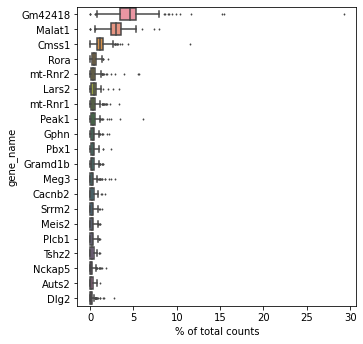

In [48]:
scanpy.pl.highest_expr_genes(myrun, n_top=20, gene_symbols="gene_name")

# STAR EM highest genes

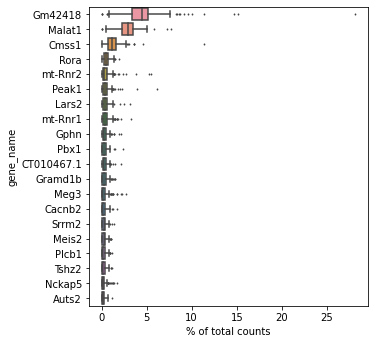

In [49]:
scanpy.pl.highest_expr_genes(myrunem, n_top=20, gene_symbols="gene_name")

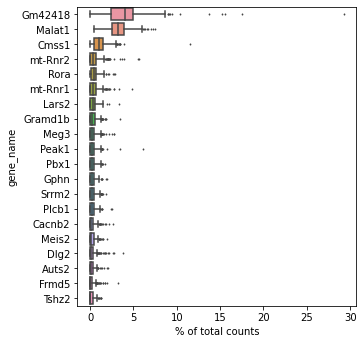

In [50]:
scanpy.pl.highest_expr_genes(myrun_filtered_collapsed, n_top=20, gene_symbols="gene_name")

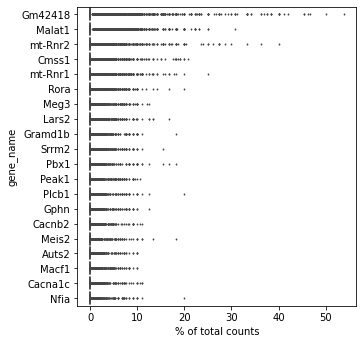

In [51]:
scanpy.pl.highest_expr_genes(myrun_raw_collapsed, n_top=20, gene_symbols="gene_name")

# UCI highest genes

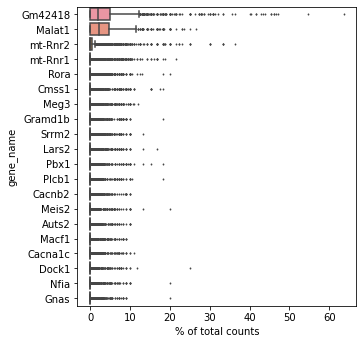

In [52]:
scanpy.pl.highest_expr_genes(ucirun, n_top=20, gene_symbols="gene_name")

# STAR expression sum

In [53]:
myrun.X.sum()

297095.0

In [54]:
myrun_raw.X.sum()

414886.0

# STAR EM expression sum

In [55]:
myrunem.X.sum()

306770.03

In [56]:
myrunem_raw.X.sum()

428539.03

# UCI expression sum

In [57]:
ucirun.X.sum()

392113.0

# WARNING

There are duplicate UCI barcodes after making them compatible with star. I think they had a _pbN after them. This code ends up using the first of the barcodes to compare with the STAR run.

In [58]:
ucirun.obs_names_make_unique()

In [59]:
def compute_spearman_pandas(left, right):
    assert left.shape == right.shape, "Shapes must be the same"

    cors=[]
    for c in left.columns:
        cors.append(scipy.stats.spearmanr(left[c], right[c])[0])
    cors = pandas.Series(cors, index=left.columns)
    return cors


In [60]:
def compute_correlations(tables):
    programs = list(tables.keys())
    cell_correlations = {}

    for name_x in programs:
        for name_y in programs[programs.index(name_x):]:
            assert tables[name_x].shape == tables[name_y].shape
            cs_cors = compute_spearman_pandas(tables[name_x], tables[name_y])
            assert len(cs_cors) == len(tables[name_x].columns)
            cell_correlations.setdefault(name_x, {})[name_y] = cs_cors
    return cell_correlations

In [61]:
def set_all_spines(ax, state):
    for name in ["left", "right", "top", "bottom"]:
        ax.spines[name].set_visible(state)
        ax.tick_params(
            axis='both', 
            which='both', 
            bottom=False,
            labelbottom=False, 
            top=False, 
            labeltop=False,
            right=False,
            labelright=False,
            left=False, 
            labelleft=False)

def plot_cell_correlation_histogram(
    table, *, programs=None, bins=50, y_annot=0.6, count_nans=False, 
    correlation_name='Spearman',
    xlim=None
):
    #fontname = 'Arial'
    override_labels = {
        'Alevin': 'Salmon Alevin (EM)',
        'Kallisto EM': 'Kallisto Bus (EM)'
    }
    fontname = 'DejaVu Sans'
    fontsize = 14    
    if programs is None:
        programs = list(table.keys())
    cell_hists = {}
    f = pyplot.figure(figsize=(7,7))
    #f.suptitle('Per-cell {} correlation'.format(correlation_name), fontsize=fontsize)
    plot_size = len(programs)-1

    axes = f.subplots(plot_size, plot_size, sharex=True, sharey=True)
    
    for i in range(0, plot_size):
        for j in range(i+1, plot_size):
            set_all_spines(axes[i, j], False)

    if plot_size == 1:
        axes = numpy.asarray([[axes]])

    for x, name_x in enumerate(programs):
        for y, name_y in enumerate(programs[programs.index(name_x)+1:]):
            x_label = override_labels.get(name_x, name_x)
            y_label = override_labels.get(name_y, name_y)
            #plot_index = plot_size * (y+x) + x + 1
            #ax = f.add_subplot(plot_size, plot_size, plot_index)
            ax = axes[y+x, x]
            if xlim is not None:
                ax.set_xlim(xlim)
            #set_all_spines(ax, True)
            if x == 0:
                ax.set_ylabel(y_label, fontname=fontname, fontsize=fontsize)

            spearman = table[name_x][name_y]
            spearman = numpy.array(spearman)
            spearman = spearman[~numpy.isnan(spearman)]
            count = len(spearman)
            median = numpy.median(spearman)
            mean = numpy.mean(spearman)
            cell_hists.setdefault(name_x, {})[name_y] = ax.hist(spearman, bins=bins, density=True)
            nantext=""
            if count_nans:
                nantext="\nNaNs {}".format(table[name_x][name_y].isna().sum())
            ax.annotate(f'Mean {mean:0.2}\nMedian {median:0.2}\nCells {count}{nantext}', xy=(0.1, y_annot), xycoords='axes fraction')
            #ax.annotate(f'Mean {mean}\nMedian {median}\nCells {count}{nantext}', xy=(0.1, y_annot), xycoords='axes fraction')
    for y in range(plot_size):
        x_label = override_labels.get(programs[y], programs[y])
        axes[0, y].set_title(x_label, fontname=fontname, fontsize=fontsize)
        axes[plot_size-1, y].set_xlabel(x_label, fontname=fontname, fontsize=fontsize)
    #f.tight_layout()
    return f

In [62]:
common_cell_set = set(ucirun.obs_names).intersection(myrun.obs_names)
common_gene_set = set(ucirun.var_names).intersection(myrun.var_names)

common_cells = [x for x in ucirun.obs_names if x in common_cell_set]
common_genes = [x for x in ucirun.var_names if x in common_gene_set]

In [63]:
ucirun.obs_names

Index(['AAGACGGAAATGTTGC_0', 'ATCCTGTATGGCTTCA_0', 'CTCAATGATCTTCACA_0',
       'TAGGATGAAGTGGTCA_0', 'ACTATGCAAATGTTGC_0', 'CTAAGGTCAGCCATGC_0',
       'ACTATGCACGACACAC_0', 'GACAGTGCAATGTTGC_0', 'CGACACACAAGGTACA_0',
       'CTAAGGTCAATGTTGC_0',
       ...
       'ATCATTCCCGCATACA_0', 'ACAAGCTACTGTAGCC_0', 'CAGCGTTAGTCGTAGA_0',
       'GTCGTAGAGTGTTCTA_0', 'AAGACGGAACTATGCA_0', 'GTCGTAGAGTCGTAGA_0',
       'TCTTCACAAGATCGCA_0', 'GTCGTAGACATACCAA_0', 'ATAGCGACGAGTTAGC_0',
       'CAACCACAAGCCATGC_0'],
      dtype='object', name='cell_barcode', length=2721)

In [64]:
myrun[common_cells,common_genes]

View of AnnData object with n_obs × n_vars = 194 × 13996
    obs: 'cell_barcodes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [65]:
datasets = {
    "my": myrun[common_cells, common_genes].to_df().T,
    "my col": myrun_filtered_collapsed[common_cells, common_genes].to_df().T,
    "my em": myrunem[common_cells, common_genes].to_df().T,
    "my em col": myrunem_filtered_collapsed[common_cells, common_genes].to_df().T,
    "ucirun": ucirun[common_cells, common_genes].to_df().T,
}

cors = compute_correlations(datasets)

# All vs All filtered Spearman Correlation

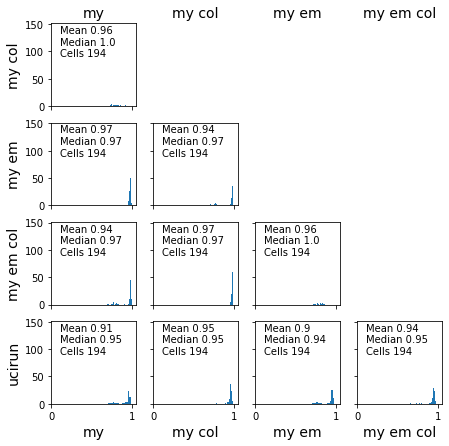

In [66]:
f = plot_cell_correlation_histogram(cors)

# All vs All less filtered Spearman Correlation calculation

In [74]:
raw_common_cell_set = set(ucirun.obs_names).intersection(myrun_raw.obs_names)
raw_common_gene_set = set(ucirun.var_names).intersection(myrun_raw.var_names)

raw_common_cells = [x for x in ucirun.obs_names if x in raw_common_cell_set]
raw_common_genes = [x for x in ucirun.var_names if x in raw_common_gene_set]

raw_datasets = {
    "my": myrun_raw[raw_common_cells, raw_common_genes].to_df().T,
    #"my col": myrun_raw_collapsed[raw_common_cells, raw_common_genes].to_df().T,
    #"my em col": myrunem_raw_collapsed[raw_common_cells, raw_common_genes].to_df().T,
    "my em raw": myrunem_raw[raw_common_cells, raw_common_genes].to_df().T,
    "ucirun": ucirun[raw_common_cells, raw_common_genes].to_df().T,
}

raw_cors = compute_correlations(raw_datasets)

In [75]:
myrun_raw[raw_common_cells, :].X.sum(), myrun_raw[:, raw_common_genes].X.sum(), myrun_raw[raw_common_cells, raw_common_genes].X.sum()

(414835.0, 413326.0, 413275.0)

# All vs All less filtered Spearman Correlation

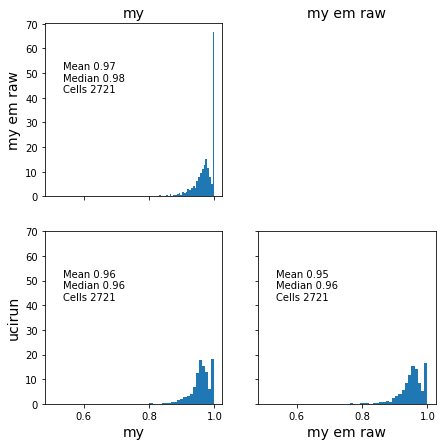

In [76]:
f = plot_cell_correlation_histogram(raw_cors)

In [77]:
myrun[:, myrun.var["total_counts"] > 0]

View of AnnData object with n_obs × n_vars = 194 × 13572
    obs: 'cell_barcodes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [78]:
myrun_raw[:, myrun_raw.var["total_counts"] > 0]

View of AnnData object with n_obs × n_vars = 442368 × 14064
    obs: 'cell_barcodes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [79]:
myrun_raw[myrun_raw.obs["total_counts"]>0]

View of AnnData object with n_obs × n_vars = 2724 × 81881
    obs: 'cell_barcodes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [80]:
ucirun[ucirun.obs["total_counts"]>0]

View of AnnData object with n_obs × n_vars = 2721 × 13996
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'